In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string     

In [2]:
data = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/train.csv')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
data = data.drop('id',1)

<ipython-input-3-02b556c81868>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('id',1)


In [4]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


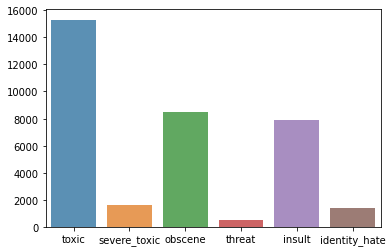

In [5]:
val_counts = data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum()
ax = sns.barplot(val_counts.index, val_counts.values, alpha=0.8)

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [7]:
data['comment_text'] = data['comment_text'].apply(lambda x: clean_text(x))

In [9]:
data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired '

In [12]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['comment_text'].values)
X = tokenizer.texts_to_sequences(data['comment_text'].values)
X = pad_sequences(X)
#X[:2]

In [13]:
X

array([[ 0,  0,  0, ..., 30,  1, 27],
       [ 0,  0,  0, ...,  0, 13, 21],
       [ 0,  0,  0, ...,  2,  1,  1],
       ...,
       [ 0,  0,  0, ...,  0, 23, 12],
       [ 0,  0,  0, ...,  9,  7, 11],
       [ 0,  0,  0, ...,  6, 18,  3]], dtype=int32)

In [14]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 903, 128)          4096      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 903, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 6)                 1182      
Total params: 260,078
Trainable params: 260,078
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
Y = data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(127656, 903) (127656, 6)
(31915, 903) (31915, 6)


In [ ]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
998/998 [==============================] - 3185s 3s/step - loss: 0.3401 - accuracy: 0.0358
Epoch 2/15
998/998 [==============================] - 3140s 3s/step - loss: 0.3390 - accuracy: 0.0017
Epoch 3/15
998/998 [==============================] - 3180s 3s/step - loss: 0.3380 - accuracy: 0.0021
Epoch 4/15
998/998 [==============================] - 19914s 20s/step - loss: 0.3379 - accuracy: 0.0123
Epoch 5/15
879/998 [=========================>....] - ETA: 2:18:23 - loss: 0.3413 - accuracy: 0.0399